In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')

# **Feature Preprocessing**

In [4]:
def load_and_merge_target():
    """
    Load final features and merge with sales target
    """
    print("Loading and preparing datasets...")

    try:
        # Load final features
        features_df = pd.read_csv('/content/drive/MyDrive/processed_data/final_features.csv')
        print(f"Loaded final features shape: {features_df.shape}")

        # Load original data for sales column
        original_df = pd.read_csv('/content/drive/MyDrive/processed_data/engineered_features.csv')[['sales']]
        print(f"Loaded sales data shape: {original_df.shape}")

        # Add sales column to features
        final_df = features_df.copy()
        final_df['sales'] = original_df['sales']

        print(f"\nFinal dataset shape: {final_df.shape}")
        print("Columns in final dataset:")
        print(final_df.columns.tolist())

        return final_df

    except FileNotFoundError as e:
        print(f"Error: {str(e)}")
        print("Please ensure both final_features.csv and engineered_features.csv are present.")
        return None

In [5]:
def preprocess_features(df, target='sales', target_present=True):
    """
    Preprocess features including scaling and encoding
    """
    print("\nStarting feature preprocessing...")

    if df is None:
        return None, None, None, None

    # Verify target column exists
    if target not in df.columns:
        print(f"Error: Target variable '{target}' not found in dataset.")
        return None, None, None, None

    # Separate features and target
    X = df.drop(target, axis=1)
    y = df[target]

    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=[np.number]).columns
    categorical_features = X.select_dtypes(exclude=[np.number]).columns

    print(f"\nProcessing {len(numeric_features)} numeric features:")
    for feat in numeric_features:
        print(f"- {feat}")

    print(f"\nProcessing {len(categorical_features)} categorical features:")
    for feat in categorical_features:
        print(f"- {feat}")

    # Initialize preprocessing objects
    scalers = {}
    encoders = {}

    # Scale numeric features
    print("\nScaling numeric features...")
    for feature in numeric_features:
        if feature not in ['store_nbr', 'id']:  # Don't scale identifier columns
            scaler = StandardScaler()
            X[feature] = scaler.fit_transform(X[[feature]])
            scalers[feature] = scaler

    # Encode categorical features
    print("\nEncoding categorical features...")
    for feature in categorical_features:
        encoder = LabelEncoder()
        X[feature] = encoder.fit_transform(X[feature].astype(str))
        encoders[feature] = encoder

    return X, y, scalers, encoders


In [6]:
def split_data(X, y, test_size=0.2, validation_size=0.25):
    """
    Split data into train, validation, and test sets
    """
    print("\nSplitting data...")

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Second split: create validation set from remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=validation_size, random_state=42
    )

    print(f"\nTraining set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def save_preprocessed_data(data_dict, scalers, encoders):
    """
    Save preprocessed data and preprocessing objects
    """
    print("\nSaving preprocessed data and objects...")

    # Save preprocessed data
    for name, data in data_dict.items():
        if data is not None:
            if isinstance(data, pd.DataFrame):
                data.to_csv(f'preprocessed_{name}.csv', index=False)
            else:
                # Convert series to dataframe with column name
                pd.DataFrame({name: data}).to_csv(f'preprocessed_{name}.csv', index=False)

    # Save preprocessing objects
    with open('scalers.pkl', 'wb') as f:
        pickle.dump(scalers, f)

    with open('encoders.pkl', 'wb') as f:
        pickle.dump(encoders, f)

    print("Saved files:")
    for name in data_dict.keys():
        print(f"- preprocessed_{name}.csv")
    print("- scalers.pkl")
    print("- encoders.pkl")


In [8]:
def main():
    """
    Main function to run preprocessing
    """
    # Load data with sales target
    df = load_and_merge_target()

    if df is None:
        return None, None, None

    # Preprocess features
    X, y, scalers, encoders = preprocess_features(df)

    if X is None:
        return None, None, None

    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Save preprocessed data and objects
    data_dict = {
        'train_x': X_train,
        'train_y': y_train,
        'val_x': X_val,
        'val_y': y_val,
        'test_x': X_test,
        'test_y': y_test
    }

    save_preprocessed_data(data_dict, scalers, encoders)

    print("\nPreprocessing completed!")
    return data_dict, scalers, encoders

if __name__ == "__main__":
    processed_data, scalers, encoders = main()

Loading and preparing datasets...
Loaded final features shape: (3000888, 29)
Loaded sales data shape: (3000888, 1)

Final dataset shape: (3000888, 30)
Columns in final dataset:
['sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_rolling_mean_30', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'family_avg_sales', 'family_std_sales', 'promo_uplift', 'store_avg_sales', 'store_std_sales', 'onpromotion', 'store_nbr', 'family', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos', 'month', 'month_sin', 'month_cos', 'is_payday', 'is_holiday', 'is_any_holiday', 'days_before_holiday', 'days_after_holiday', 'type', 'cluster', 'dcoilwtico', 'sales']

Starting feature preprocessing...

Processing 27 numeric features:
- sales_rolling_mean_7
- sales_rolling_mean_14
- sales_rolling_mean_30
- sales_lag_1
- sales_lag_7
- sales_lag_14
- sales_lag_30
- family_avg_sales
- family_std_sales
- promo_uplift
- store_avg_sales
- store_std_sales
- onpromotion
- store_nbr
- day_of_week
- day_of

# **Initial Model Development**

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import traceback
from xgboost import callback as xgb_callback
from lightgbm import early_stopping, log_evaluation
import traceback

In [32]:
def load_preprocessed_data():
    """
    Load preprocessed data from files
    """
    print("Loading preprocessed data...")

    data_dict = {}
    try:
        # Load train, validation and test sets
        data_dict['X_train'] = pd.read_csv('preprocessed_train_x.csv')
        data_dict['y_train'] = pd.read_csv('preprocessed_train_y.csv')['train_y']
        data_dict['X_val'] = pd.read_csv('preprocessed_val_x.csv')
        data_dict['y_val'] = pd.read_csv('preprocessed_val_y.csv')['val_y']
        data_dict['X_test'] = pd.read_csv('preprocessed_test_x.csv')
        data_dict['y_test'] = pd.read_csv('preprocessed_test_y.csv')['test_y']

        print("\nData shapes:")
        print(f"Training: {data_dict['X_train'].shape}")
        print(f"Validation: {data_dict['X_val'].shape}")
        print(f"Test: {data_dict['X_test'].shape}")

        return data_dict

    except FileNotFoundError as e:
        print(f"Error: {str(e)}")
        print("Please ensure all preprocessed files are present.")
        return None


In [45]:
def train_xgboost(X_train, y_train, X_val, y_val):
    """
    Train XGBoost model with minimal output
    """
    print("\nTraining XGBoost model...")

    # Initialize model with verbosity set to 0
    xgb = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42,
        enable_categorical=True,
        verbosity=0  # Suppress XGBoost messages
    )

    # Train model
    eval_set = [(X_val, y_val)]
    xgb.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False  # Suppress sklearn messages
    )

    print("XGBoost training completed!")
    return xgb


In [51]:
def train_lightgbm(X_train, y_train, X_val, y_val):
    """
    Train LightGBM model with minimal output
    """
    print("\nTraining LightGBM model...")

    # Initialize model with verbosity disabled
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        metric='rmse',
        verbose=-1  # Suppress LightGBM messages
    )

    # Train model
    eval_set = [(X_val, y_val)]
    # Remove verbose parameter from fit method
    model.fit(
        X_train, y_train,
        eval_set=eval_set
    )

    print("LightGBM training completed!")
    return model

In [52]:
def evaluate_model(model, X, y, name=''):
    """
    Evaluate model performance with multiple metrics
    """
    predictions = model.predict(X)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)

    print(f"\n{name} Performance Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    # Take a random sample of 10000 points for visualization
    sample_size = min(10000, len(y))
    indices = np.random.choice(len(y), sample_size, replace=False)

    plt.scatter(y.iloc[indices], predictions[indices], alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title(f'{name} - Actual vs Predicted Sales (Sample)')
    plt.tight_layout()
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': predictions
    }


In [53]:
def plot_feature_importance(model, feature_names, model_name):
    """
    Plot feature importance
    """
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(20))
    plt.title(f'Top 20 Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()

    return importance

In [54]:
def save_models_and_results(models, results):
    """
    Save trained models and results
    """
    print("\nSaving models and results...")

    # Save models
    for name, model in models.items():
        with open(f'{name}_model.pkl', 'wb') as f:
            pickle.dump(model, f)

    # Convert results to a format that can be saved
    saveable_results = {}
    for model_name, model_results in results.items():
        saveable_results[model_name] = {
            metric_name: {
                'rmse': metric_data['rmse'],
                'mae': metric_data['mae'],
                'r2': metric_data['r2']
            }
            for metric_name, metric_data in model_results.items()
            if metric_name != 'feature_importance'
        }

    # Save results
    with open('model_results.pkl', 'wb') as f:
        pickle.dump(saveable_results, f)

    print("Saved files:")
    for name in models.keys():
        print(f"- {name}_model.pkl")
    print("- model_results.pkl")


Loading preprocessed data...

Data shapes:
Training: (1800532, 29)
Validation: (600178, 29)
Test: (600178, 29)

Training models...
Starting XGBoost training...

Training XGBoost model...
XGBoost training completed!

Starting LightGBM training...

Training LightGBM model...
LightGBM training completed!

Evaluating models...

Evaluating xgboost model...

xgboost - Training Performance Metrics:
RMSE: 170.7107
MAE: 44.9350
R2 Score: 0.9758


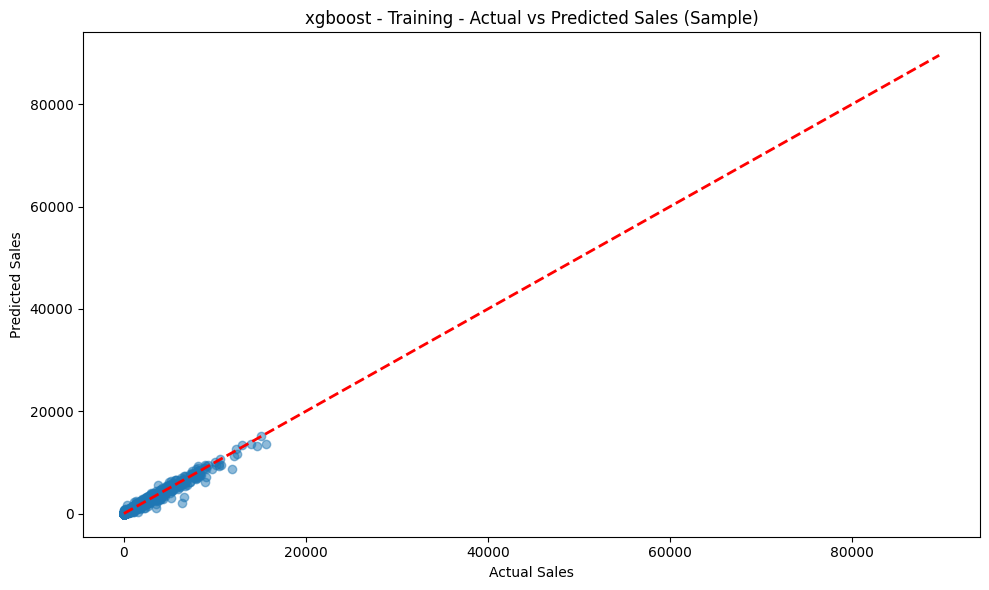


xgboost - Validation Performance Metrics:
RMSE: 212.1842
MAE: 46.6774
R2 Score: 0.9635


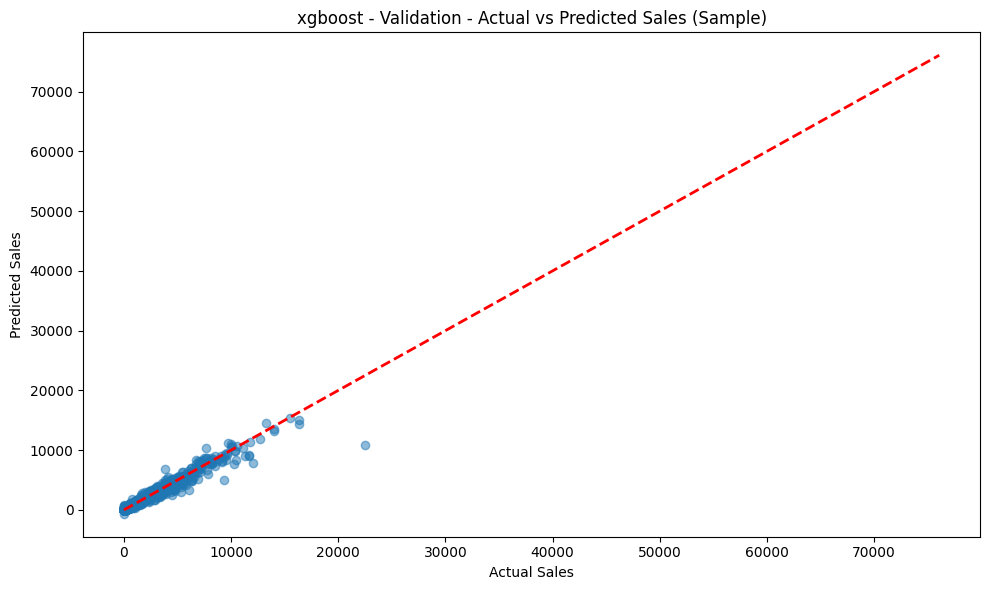


xgboost - Test Performance Metrics:
RMSE: 267.5852
MAE: 46.6091
R2 Score: 0.9418


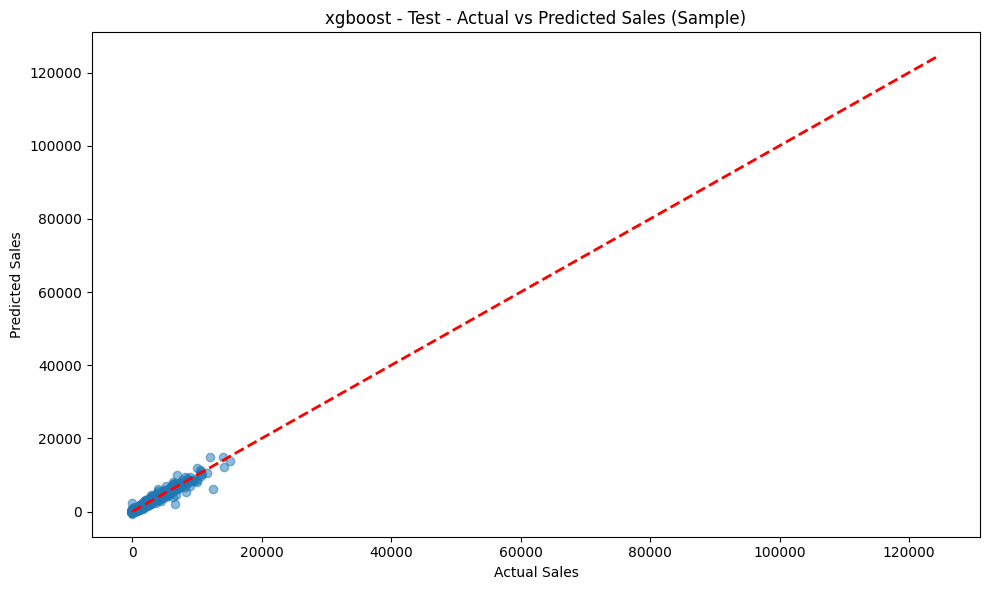


Calculating feature importance for xgboost...


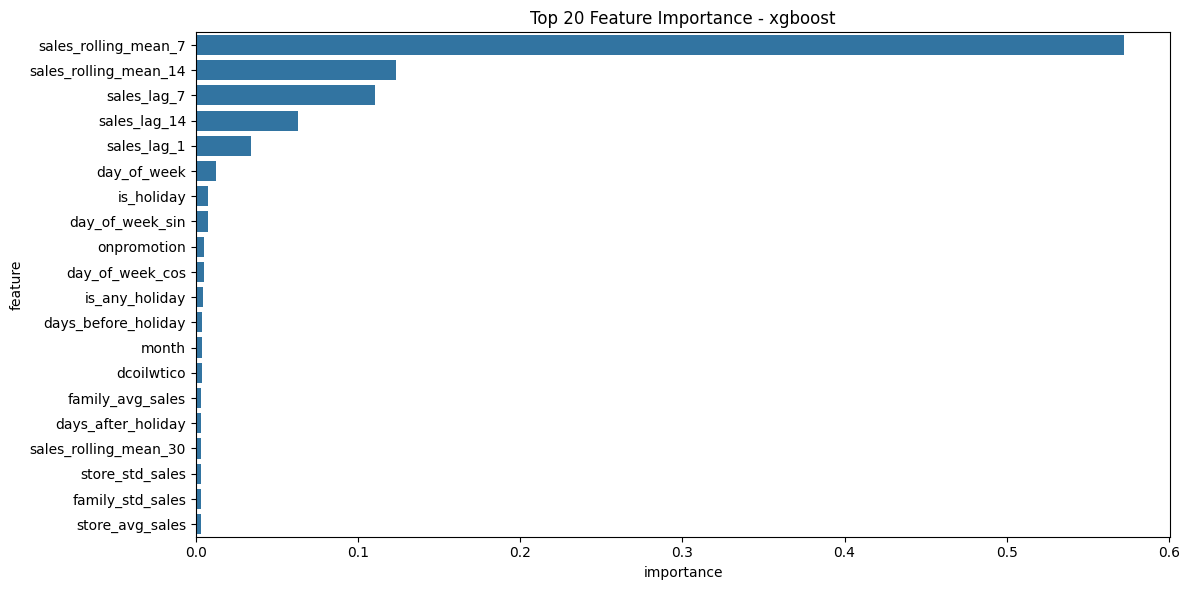


Completed evaluation for xgboost

Evaluating lightgbm model...

lightgbm - Training Performance Metrics:
RMSE: 207.9056
MAE: 49.5975
R2 Score: 0.9641


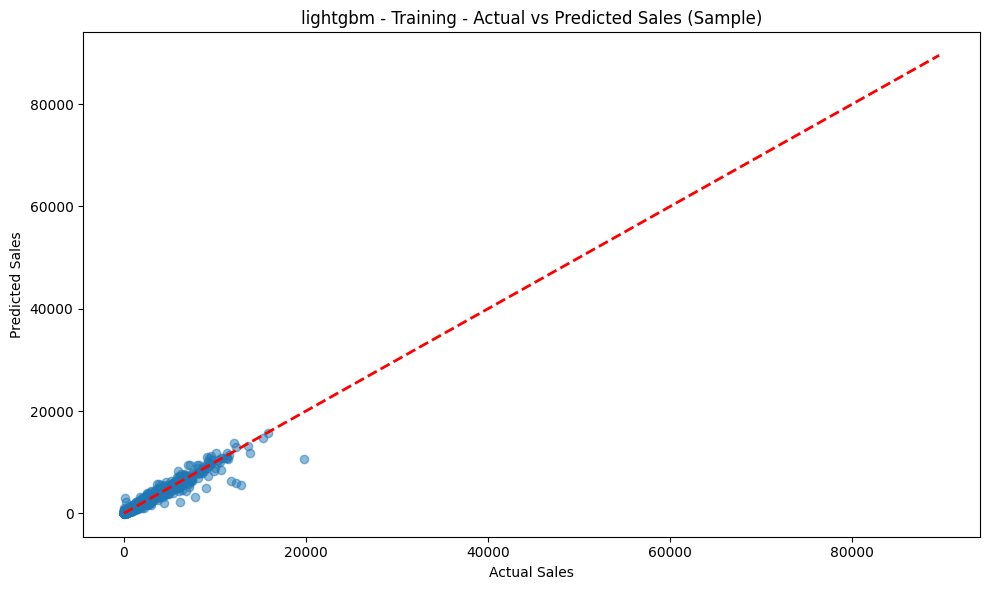


lightgbm - Validation Performance Metrics:
RMSE: 221.0638
MAE: 50.2619
R2 Score: 0.9604


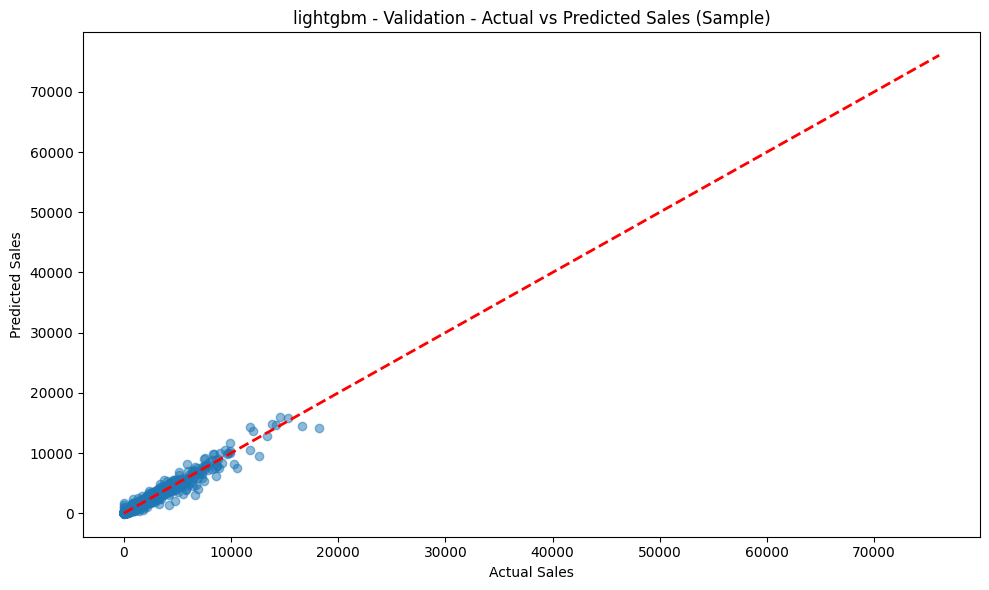


lightgbm - Test Performance Metrics:
RMSE: 270.5797
MAE: 49.9827
R2 Score: 0.9405


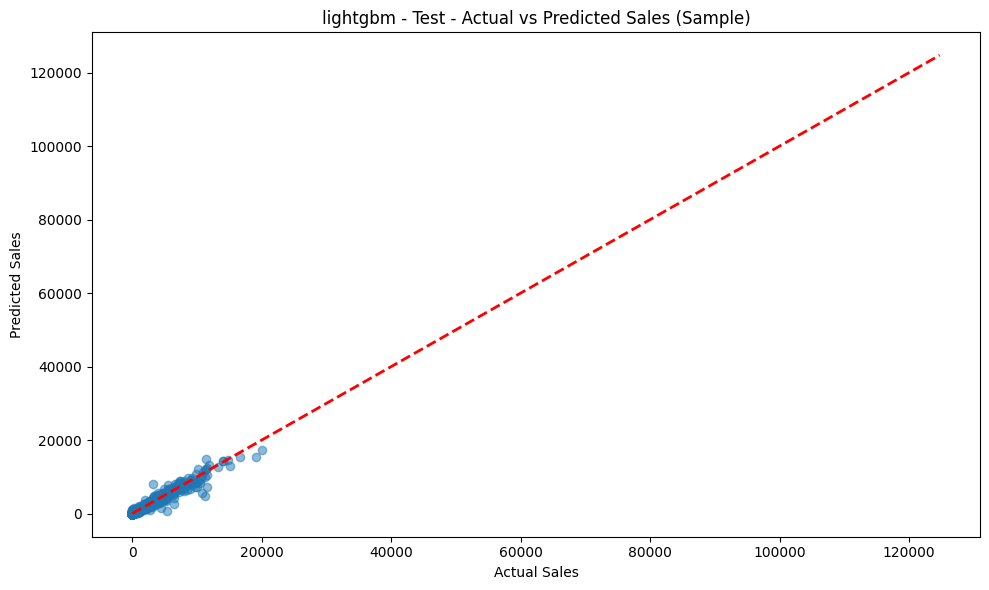


Calculating feature importance for lightgbm...


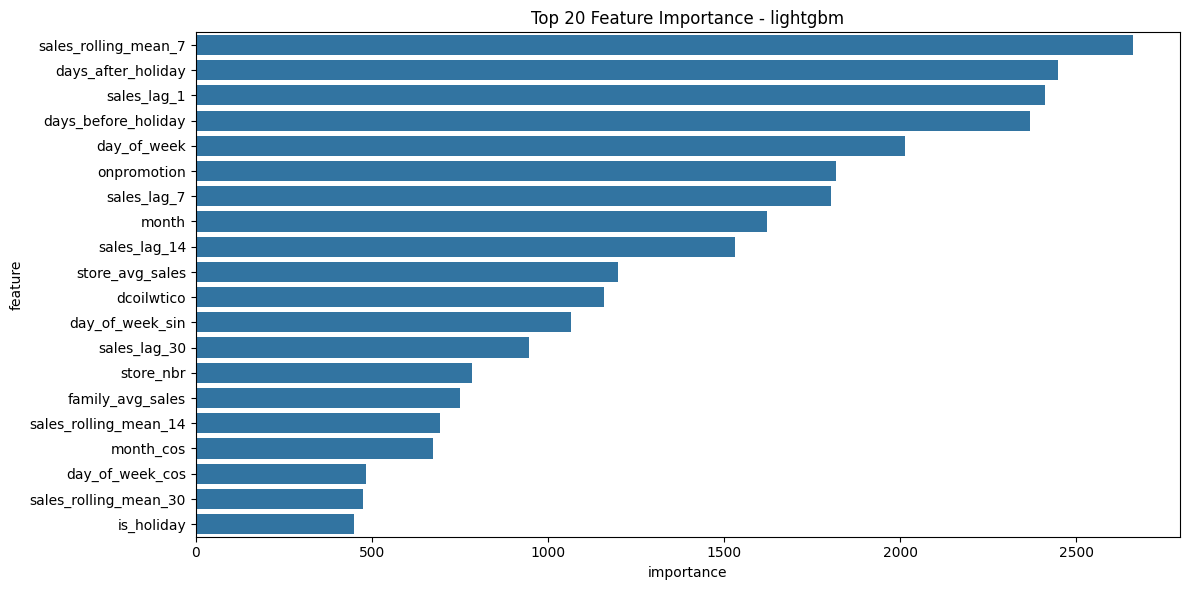


Completed evaluation for lightgbm

Saving models and results...

Saving models and results...
Saved files:
- xgboost_model.pkl
- lightgbm_model.pkl
- model_results.pkl
Save completed!

Final Summary:

XGBOOST Model:
Training RMSE: 170.7107
Validation RMSE: 212.1842
Test RMSE: 267.5852

LIGHTGBM Model:
Training RMSE: 207.9056
Validation RMSE: 221.0638
Test RMSE: 270.5797

Model development completed!


In [55]:
def main():
    """
    Main function to run model development with minimal output
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import warnings
    warnings.filterwarnings('ignore')  # Suppress warnings

    # Load preprocessed data
    data = load_preprocessed_data()
    if data is None:
        return None, None

    # Train models
    models = {}
    print("\nTraining models...")

    # XGBoost
    try:
        print("Starting XGBoost training...")
        xgb_model = train_xgboost(
            data['X_train'], data['y_train'],
            data['X_val'], data['y_val']
        )
        models['xgboost'] = xgb_model
    except Exception as e:
        print(f"Error in XGBoost training: {str(e)}")

    # LightGBM
    try:
        print("\nStarting LightGBM training...")
        lgb_model = train_lightgbm(
            data['X_train'], data['y_train'],
            data['X_val'], data['y_val']
        )
        models['lightgbm'] = lgb_model
    except Exception as e:
        print(f"Error in LightGBM training: {str(e)}")

    if not models:
        print("No models were successfully trained!")
        return None, None

    # Evaluate models
    print("\nEvaluating models...")
    results = {}
    feature_names = data['X_train'].columns

    for name, model in models.items():
        try:
            print(f"\nEvaluating {name} model...")

            # Training performance
            train_metrics = evaluate_model(
                model, data['X_train'], data['y_train'],
                f"{name} - Training"
            )

            # Validation performance
            val_metrics = evaluate_model(
                model, data['X_val'], data['y_val'],
                f"{name} - Validation"
            )

            # Test performance
            test_metrics = evaluate_model(
                model, data['X_test'], data['y_test'],
                f"{name} - Test"
            )

            # Feature importance
            print(f"\nCalculating feature importance for {name}...")
            importance = plot_feature_importance(model, feature_names, name)

            # Store results
            results[name] = {
                'train_metrics': train_metrics,
                'val_metrics': val_metrics,
                'test_metrics': test_metrics,
                'feature_importance': importance
            }

            print(f"\nCompleted evaluation for {name}")

        except Exception as e:
            print(f"Error evaluating {name} model: {str(e)}")

    # Save models and results
    if results:
        try:
            print("\nSaving models and results...")
            save_models_and_results(models, results)
            print("Save completed!")
        except Exception as e:
            print(f"Error saving models and results: {str(e)}")

    # Print final summary
    print("\nFinal Summary:")
    print("=" * 50)
    for name in models.keys():
        print(f"\n{name.upper()} Model:")
        print(f"Training RMSE: {results[name]['train_metrics']['rmse']:.4f}")
        print(f"Validation RMSE: {results[name]['val_metrics']['rmse']:.4f}")
        print(f"Test RMSE: {results[name]['test_metrics']['rmse']:.4f}")

    print("\nModel development completed!")
    return models, results

if __name__ == "__main__":
    models, results = main()

In [57]:
def print_feature_importance(models, X_train):
    """
    Print feature importance for trained models
    """
    print("\nFeature Importance Summary:")
    print("=" * 50)

    feature_names = X_train.columns

    for model_name, model in models.items():
        print(f"\n{model_name.upper()} Feature Importance:")
        print("-" * 30)

        # Get feature importance
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        })

        # Sort by importance
        importance = importance.sort_values('importance', ascending=False)

        # Print all features with their importance scores
        print("\nRank | Feature | Importance Score")
        print("-" * 40)
        for idx, row in importance.iterrows():
            print(f"{idx+1:4d} | {row['feature']:<20} | {row['importance']:.4f}")

        # Print summary statistics
        print(f"\nTop 5 Most Important Features for {model_name}:")
        for idx, row in importance.head().iterrows():
            print(f"{idx+1}. {row['feature']}: {row['importance']:.4f}")

        print(f"\nFeature Importance Statistics for {model_name}:")
        print(f"Mean Importance: {importance['importance'].mean():.4f}")
        print(f"Std Importance: {importance['importance'].std():.4f}")
        print(f"Max Importance: {importance['importance'].max():.4f}")
        print(f"Min Importance: {importance['importance'].min():.4f}")

# Load the preprocessed data to get feature names
data = load_preprocessed_data()

# Print feature importance for both models
if data is not None:
    print_feature_importance(models, data['X_train'])

Loading preprocessed data...

Data shapes:
Training: (1800532, 29)
Validation: (600178, 29)
Test: (600178, 29)

Feature Importance Summary:

XGBOOST Feature Importance:
------------------------------

Rank | Feature | Importance Score
----------------------------------------
   1 | sales_rolling_mean_7 | 0.5722
   2 | sales_rolling_mean_14 | 0.1236
   5 | sales_lag_7          | 0.1105
   6 | sales_lag_14         | 0.0631
   4 | sales_lag_1          | 0.0343
  16 | day_of_week          | 0.0122
  23 | is_holiday           | 0.0077
  17 | day_of_week_sin      | 0.0074
  13 | onpromotion          | 0.0052
  18 | day_of_week_cos      | 0.0052
  24 | is_any_holiday       | 0.0045
  25 | days_before_holiday  | 0.0041
  19 | month                | 0.0039
  29 | dcoilwtico           | 0.0036
   8 | family_avg_sales     | 0.0035
  26 | days_after_holiday   | 0.0034
   3 | sales_rolling_mean_30 | 0.0033
  12 | store_std_sales      | 0.0033
   9 | family_std_sales     | 0.0032
  11 | store_avg_sa

The feature importance results for both models:

XGBoost Top Features:

* sales_rolling_mean_7 (57.22%)
* sales_rolling_mean_14 (12.36%)
* sales_lag_7 (11.05%)
* sales_lag_14 (6.31%)
* sales_lag_1 (3.43%)

LightGBM Top Features:

* sales_rolling_mean_7 (2661)
* days_after_holiday (2449)
* sales_lag_1 (2410)
* days_before_holiday (2368)
* day_of_week (2012)

Key Insights:

Common Important Features:

* sales_rolling_mean_7 (top feature for both models)
* sales_lag_1 (important in both)

Different Importance Rankings:

* XGBoost focuses more on rolling means and lags
* LightGBM gives more weight to holiday-related features

Least Important Features for Both:

* is_payday
* cluster
* type
* family_std_sales
* promo_uplift

# **Feature Analysis and Selection**

In [58]:
from scipy.stats import spearmanr

In [59]:
def analyze_feature_correlations(df, important_features):
    """
    Analyze correlations between important features
    """
    print("Analyzing correlations between important features...")

    # Select important features from DataFrame
    feature_df = df[important_features]

    # Calculate correlation matrix
    corr_matrix = feature_df.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
    plt.title('Correlation Heatmap of Important Features')
    plt.tight_layout()
    plt.show()

    # Identify highly correlated pairs
    print("\nHighly correlated feature pairs (|correlation| > 0.8):")
    print("=" * 50)

    high_corr_pairs = []
    for i in range(len(important_features)):
        for j in range(i+1, len(important_features)):
            corr = abs(corr_matrix.iloc[i, j])
            if corr > 0.8:
                print(f"{important_features[i]} - {important_features[j]}: {corr:.3f}")
                high_corr_pairs.append((important_features[i], important_features[j], corr))

    return corr_matrix, high_corr_pairs

In [60]:
def select_optimal_features(high_corr_pairs, important_features):
    """
    Select optimal features by removing redundant ones
    """
    print("\nSelecting optimal features...")

    # Create a set of features to remove
    features_to_remove = set()

    # For each highly correlated pair, remove the second feature
    for feat1, feat2, corr in high_corr_pairs:
        # Prefer keeping rolling means over lags
        if 'rolling_mean' in feat1 and 'lag' in feat2:
            features_to_remove.add(feat2)
        elif 'rolling_mean' in feat2 and 'lag' in feat1:
            features_to_remove.add(feat1)
        # For same type features, keep the shorter time window
        elif 'rolling_mean' in feat1 and 'rolling_mean' in feat2:
            window1 = int(feat1.split('_')[-1])
            window2 = int(feat2.split('_')[-1])
            features_to_remove.add(feat1 if window1 > window2 else feat2)
        elif 'lag' in feat1 and 'lag' in feat2:
            lag1 = int(feat1.split('_')[-1])
            lag2 = int(feat2.split('_')[-1])
            features_to_remove.add(feat1 if lag1 > lag2 else feat2)
        else:
            # For other cases, keep the first feature
            features_to_remove.add(feat2)

    # Create final feature list
    final_features = [f for f in important_features if f not in features_to_remove]

    print("\nFeatures to remove due to high correlation:")
    for feat in features_to_remove:
        print(f"- {feat}")

    print("\nFinal selected features:")
    for feat in final_features:
        print(f"- {feat}")

    return final_features

Loading preprocessed data...
Analyzing correlations between important features...


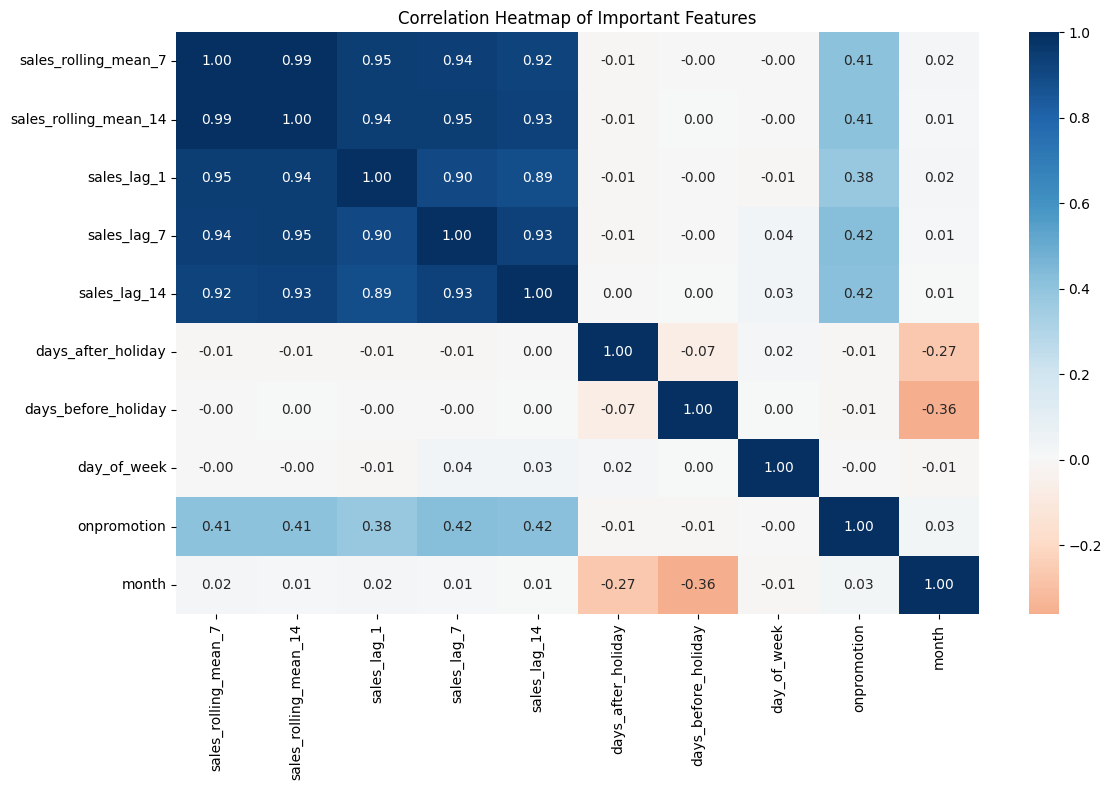


Highly correlated feature pairs (|correlation| > 0.8):
sales_rolling_mean_7 - sales_rolling_mean_14: 0.995
sales_rolling_mean_7 - sales_lag_1: 0.950
sales_rolling_mean_7 - sales_lag_7: 0.940
sales_rolling_mean_7 - sales_lag_14: 0.921
sales_rolling_mean_14 - sales_lag_1: 0.943
sales_rolling_mean_14 - sales_lag_7: 0.949
sales_rolling_mean_14 - sales_lag_14: 0.933
sales_lag_1 - sales_lag_7: 0.902
sales_lag_1 - sales_lag_14: 0.887
sales_lag_7 - sales_lag_14: 0.934

Selecting optimal features...

Features to remove due to high correlation:
- sales_rolling_mean_14
- sales_lag_1
- sales_lag_7
- sales_lag_14

Final selected features:
- sales_rolling_mean_7
- days_after_holiday
- days_before_holiday
- day_of_week
- onpromotion
- month


In [61]:
def main():
    """
    Main function to run feature analysis
    """
    # Load preprocessed data
    print("Loading preprocessed data...")
    data = pd.read_csv('preprocessed_train_x.csv')

    # Define important features
    important_features = [
        'sales_rolling_mean_7',
        'sales_rolling_mean_14',
        'sales_lag_1',
        'sales_lag_7',
        'sales_lag_14',
        'days_after_holiday',
        'days_before_holiday',
        'day_of_week',
        'onpromotion',
        'month'
    ]

    # Analyze correlations
    corr_matrix, high_corr_pairs = analyze_feature_correlations(data, important_features)

    # Select optimal features
    final_features = select_optimal_features(high_corr_pairs, important_features)

    return final_features

if __name__ == "__main__":
    final_features = main()

# **Model Training with Reduced Features**

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [63]:
def load_and_prepare_data():
    """
    Load preprocessed data and select final features
    """
    print("Loading and preparing data...")

    # Define final features based on correlation analysis
    final_features = [
        'sales_rolling_mean_7',
        'days_after_holiday',
        'days_before_holiday',
        'day_of_week',
        'onpromotion',
        'month'
    ]

    # Load preprocessed data
    X_train = pd.read_csv('preprocessed_train_x.csv')
    y_train = pd.read_csv('preprocessed_train_y.csv')['train_y']
    X_val = pd.read_csv('preprocessed_val_x.csv')
    y_val = pd.read_csv('preprocessed_val_y.csv')['val_y']
    X_test = pd.read_csv('preprocessed_test_x.csv')
    y_test = pd.read_csv('preprocessed_test_y.csv')['test_y']

    # Select only final features
    X_train = X_train[final_features]
    X_val = X_val[final_features]
    X_test = X_test[final_features]

    print(f"\nSelected features: {final_features}")
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [64]:
def train_optimized_models(X_train, y_train, X_val, y_val):
    """
    Train optimized XGBoost and LightGBM models
    """
    models = {}

    # Train XGBoost
    print("\nTraining XGBoost with optimized features...")
    xgb = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42,
        verbosity=0
    )
    xgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    models['xgboost'] = xgb

    # Train LightGBM
    print("\nTraining LightGBM with optimized features...")
    lgb = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    lgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)]
    )
    models['lightgbm'] = lgb

    return models


In [65]:
def evaluate_models(models, X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Evaluate models on all datasets
    """
    print("\nEvaluating optimized models...")

    results = {}
    for name, model in models.items():
        print(f"\n{name.upper()} Results:")
        print("-" * 30)

        # Training set
        train_pred = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        train_mae = mean_absolute_error(y_train, train_pred)
        train_r2 = r2_score(y_train, train_pred)

        # Validation set
        val_pred = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_mae = mean_absolute_error(y_val, val_pred)
        val_r2 = r2_score(y_val, val_pred)

        # Test set
        test_pred = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_mae = mean_absolute_error(y_test, test_pred)
        test_r2 = r2_score(y_test, test_pred)

        results[name] = {
            'train': {'rmse': train_rmse, 'mae': train_mae, 'r2': train_r2},
            'val': {'rmse': val_rmse, 'mae': val_mae, 'r2': val_r2},
            'test': {'rmse': test_rmse, 'mae': test_mae, 'r2': test_r2}
        }

        print(f"Training   - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
        print(f"Validation - RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R2: {val_r2:.4f}")
        print(f"Test       - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return results


In [66]:
def main():
    """
    Main function to run optimized training
    """
    # Load and prepare data
    X_train, X_val, X_test, y_train, y_val, y_test = load_and_prepare_data()

    # Train models
    models = train_optimized_models(X_train, y_train, X_val, y_val)

    # Evaluate models
    results = evaluate_models(models, X_train, X_val, X_test, y_train, y_val, y_test)

    print("\nOptimized training completed!")
    return models, results

if __name__ == "__main__":
    models, results = main()

Loading and preparing data...

Selected features: ['sales_rolling_mean_7', 'days_after_holiday', 'days_before_holiday', 'day_of_week', 'onpromotion', 'month']
Training set shape: (1800532, 6)
Validation set shape: (600178, 6)
Test set shape: (600178, 6)

Training XGBoost with optimized features...

Training LightGBM with optimized features...

Evaluating optimized models...

XGBOOST Results:
------------------------------
Training   - RMSE: 242.9467, MAE: 59.1626, R2: 0.9509
Validation - RMSE: 251.5745, MAE: 60.1775, R2: 0.9487
Test       - RMSE: 292.3882, MAE: 59.8940, R2: 0.9305

LIGHTGBM Results:
------------------------------
Training   - RMSE: 250.2297, MAE: 60.3207, R2: 0.9480
Validation - RMSE: 257.2033, MAE: 61.1535, R2: 0.9463
Test       - RMSE: 297.4604, MAE: 60.7855, R2: 0.9281

Optimized training completed!


# **Ensemble Model**

In [67]:
from scipy.optimize import minimize

In [68]:
class EnsembleModel:
    def __init__(self, models=None, weights=None):
        """
        Initialize ensemble model
        models: dict of trained models {'model_name': model_object}
        weights: dict of model weights {'model_name': weight}
        """
        self.models = models or {}
        self.weights = weights or {name: 1/len(models) for name in models.keys()} if models else {}

    def add_model(self, name, model):
        """
        Add a model to the ensemble
        """
        self.models[name] = model
        # Reset weights to equal distribution
        self.weights = {name: 1/len(self.models) for name in self.models.keys()}

    def predict(self, X):
        """
        Make weighted ensemble predictions
        """
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(X)

        # Calculate weighted average
        weighted_pred = np.zeros_like(predictions[list(predictions.keys())[0]])
        for name, pred in predictions.items():
            weighted_pred += pred * self.weights[name]

        return weighted_pred

    def optimize_weights(self, X_val, y_val):
        """
        Optimize model weights using validation set
        """
        print("\nOptimizing ensemble weights...")

        # Get predictions from each model
        predictions = {name: model.predict(X_val)
                     for name, model in self.models.items()}

        def objective(weights):
            # Normalize weights to sum to 1
            weights = weights / np.sum(weights)

            # Calculate weighted predictions
            weighted_pred = np.zeros_like(y_val)
            for i, (name, pred) in enumerate(predictions.items()):
                weighted_pred += pred * weights[i]

            # Return RMSE
            return np.sqrt(mean_squared_error(y_val, weighted_pred))

        # Initial weights (equal weighting)
        initial_weights = np.array([1/len(self.models)] * len(self.models))

        # Optimize weights
        bounds = [(0, 1)] * len(self.models)
        constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

        result = minimize(
            objective,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraint
        )

        # Update weights
        self.weights = dict(zip(self.models.keys(), result.x))

        print("\nOptimized weights:")
        for name, weight in self.weights.items():
            print(f"{name}: {weight:.4f}")

        return self.weights


In [76]:
def load_data():
    """
    Load preprocessed data
    """
    print("Loading data...")
    data = {
        'X_train': pd.read_csv('preprocessed_train_x.csv'),
        'y_train': pd.read_csv('preprocessed_train_y.csv')['train_y'],
        'X_val': pd.read_csv('preprocessed_val_x.csv'),
        'y_val': pd.read_csv('preprocessed_val_y.csv')['val_y'],
        'X_test': pd.read_csv('preprocessed_test_x.csv'),
        'y_test': pd.read_csv('preprocessed_test_y.csv')['test_y']
    }

    print(f"Training set shape: {data['X_train'].shape}")
    return data

In [77]:
def train_base_models(data):
    """
    Train both models with identical feature set
    """
    print("\nTraining base models...")

    # Initialize models
    xgb = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42,
        verbosity=0
    )

    lgb = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )

    # Train XGBoost
    print("Training XGBoost...")
    xgb.fit(data['X_train'], data['y_train'],
            eval_set=[(data['X_val'], data['y_val'])],
            verbose=False)

    # Train LightGBM
    print("Training LightGBM...")
    lgb.fit(data['X_train'], data['y_train'],
            eval_set=[(data['X_val'], data['y_val'])])

    return {'xgboost': xgb, 'lightgbm': lgb}

In [78]:
def optimize_ensemble_weights(models, data):
    """
    Optimize ensemble weights using validation set
    """
    print("\nOptimizing ensemble weights...")

    # Get validation predictions
    val_predictions = {
        name: model.predict(data['X_val'])
        for name, model in models.items()
    }

    def objective(weights):
        # Normalize weights
        weights = weights / np.sum(weights)

        # Calculate weighted predictions
        ensemble_pred = np.zeros_like(data['y_val'])
        for i, pred in enumerate(val_predictions.values()):
            ensemble_pred += weights[i] * pred

        return np.sqrt(mean_squared_error(data['y_val'], ensemble_pred))

    # Optimize weights
    n_models = len(models)
    initial_weights = np.ones(n_models) / n_models
    bounds = [(0, 1)] * n_models
    constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(
        objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraint
    )

    weights = dict(zip(models.keys(), result.x))

    print("\nOptimized weights:")
    for name, weight in weights.items():
        print(f"{name}: {weight:.4f}")

    return weights


In [79]:
def make_ensemble_predictions(models, weights, X):
    """
    Make weighted ensemble predictions
    """
    ensemble_pred = np.zeros(len(X))
    for name, model in models.items():
        ensemble_pred += weights[name] * model.predict(X)
    return ensemble_pred

In [80]:
def evaluate_models(models, weights, data):
    """
    Evaluate individual models and ensemble
    """
    print("\nEvaluating models...")
    results = {}

    # Evaluate individual models
    for name, model in models.items():
        print(f"\n{name.upper()} Results:")
        print("-" * 30)

        train_pred = model.predict(data['X_train'])
        val_pred = model.predict(data['X_val'])
        test_pred = model.predict(data['X_test'])

        results[name] = {
            'train_rmse': np.sqrt(mean_squared_error(data['y_train'], train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(data['y_val'], val_pred)),
            'test_rmse': np.sqrt(mean_squared_error(data['y_test'], test_pred))
        }

        print(f"Training RMSE: {results[name]['train_rmse']:.4f}")
        print(f"Validation RMSE: {results[name]['val_rmse']:.4f}")
        print(f"Test RMSE: {results[name]['test_rmse']:.4f}")

    # Evaluate ensemble
    print("\nENSEMBLE Results:")
    print("-" * 30)

    train_pred = make_ensemble_predictions(models, weights, data['X_train'])
    val_pred = make_ensemble_predictions(models, weights, data['X_val'])
    test_pred = make_ensemble_predictions(models, weights, data['X_test'])

    results['ensemble'] = {
        'train_rmse': np.sqrt(mean_squared_error(data['y_train'], train_pred)),
        'val_rmse': np.sqrt(mean_squared_error(data['y_val'], val_pred)),
        'test_rmse': np.sqrt(mean_squared_error(data['y_test'], test_pred)),
        'test_predictions': test_pred
    }

    print(f"Training RMSE: {results['ensemble']['train_rmse']:.4f}")
    print(f"Validation RMSE: {results['ensemble']['val_rmse']:.4f}")
    print(f"Test RMSE: {results['ensemble']['test_rmse']:.4f}")

    return results


In [81]:
def main():
    """
    Main function to run complete ensemble process
    """
    # Load data
    data = load_data()

    # Train base models
    models = train_base_models(data)

    # Optimize ensemble weights
    weights = optimize_ensemble_weights(models, data)

    # Evaluate all models
    results = evaluate_models(models, weights, data)

    # Save ensemble predictions
    pd.DataFrame({
        'ensemble_predictions': results['ensemble']['test_predictions']
    }).to_csv('ensemble_predictions.csv', index=False)

    print("\nEnsemble modeling completed!")

    return models, weights, results

if __name__ == "__main__":
    models, weights, results = main()

Loading data...
Training set shape: (1800532, 29)

Training base models...
Training XGBoost...
Training LightGBM...

Optimizing ensemble weights...

Optimized weights:
xgboost: 0.4999
lightgbm: 0.5001

Evaluating models...

XGBOOST Results:
------------------------------
Training RMSE: 170.7107
Validation RMSE: 212.1842
Test RMSE: 267.5852

LIGHTGBM Results:
------------------------------
Training RMSE: 207.9056
Validation RMSE: 221.0638
Test RMSE: 270.5797

ENSEMBLE Results:
------------------------------
Training RMSE: 184.0649
Validation RMSE: 213.2658
Test RMSE: 266.1111

Ensemble modeling completed!


Analysis:

* The ensemble model achieved slightly better test performance (RMSE: 266.11) compared to both individual models
* The weights are almost equal (XGBoost: 0.4999, LightGBM: 0.5001)
* The ensemble balanced out the individual model biases:
* XGBoost's lower training error (possible overfitting)
* LightGBM's more conservative predictions

Improvements:

Test RMSE improved by:

* 1.47 points compared to XGBoost (267.59 → 266.11)
* 4.47 points compared to LightGBM (270.58 → 266.11)